# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler, Normalizer

from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import json
import warnings
import os
import ast

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [2]:
config_url = '../../hourlyAPI/config/coins/coins_to_track.json'
f = open(config_url)
tracked_coins = ast.literal_eval(json.load(f)['coins'])
f.close()
print(tracked_coins)

['DCR', 'CTSI', 'BTC', 'FTM', 'TRB', 'MANA', 'BAT', 'GXS', 'STORM', 'OMG', 'STMX', 'WAN', 'IOST', 'NMR', 'FET', 'ICX', 'MATIC', 'SKL', 'VET', 'KEEP', 'ALGO', 'DOGE', 'AXS', 'TRX', 'BNT', 'SAND', 'RUNE', 'HBAR', 'WAVES', 'FUN', 'ARPA', 'CREAM', 'ETH', 'DOCK', 'NEXO', 'SRM', 'LTO', 'ETC', 'BTS', 'DOT', 'VTH', 'EOS', 'ONT', 'AGLD', 'NKN', 'CRV', 'CELR', 'CRO', 'OCEAN', 'CAKE', 'MDX', 'CELO', 'SXP', 'RVN', 'QTUM', 'ZEC', 'AUDIO', 'ACH', 'AVAX', 'SUSHI', 'ANT', 'UMA', 'FIL', 'BAND', 'BEAM', 'ATOM', 'UNI', 'TOMO', 'ERD', 'ENJ', 'PERL', 'YFI', 'CHZ', 'FTT', 'SC', 'WBTC', 'API3', 'ZIL', 'BCH', 'CHR', 'AAVE', 'DENT', 'MKR', 'HT', 'REN', 'COTI', 'CEL', 'PNT', 'HIVE', '1INCH', 'HOT', 'AMP', 'LTC', 'ADA', 'SNX', 'IOTX', 'MITH', 'TFUEL', 'XMR', 'ARDR', 'RLY', 'PERP', 'LUNA', 'REQ', 'ZRX', 'NEO', 'MFT', 'WRX', 'HC', 'REEF', 'STORJ', 'NULS', 'BAL', 'STPT', 'SHIB', 'NANO', 'DASH', 'RLC', 'DATA', 'KSM', 'THETA', 'LINK', 'MTL', 'SOL', 'DGB', 'GRT', 'AION', 'XLM', 'COMP', 'DUSK', 'MTA', 'BNB', 'OGN', 'XT

In [8]:
def load_coin_dataset(coin):
    url = '../../data/coins_tracked/' + coin
    years = ['2019', '2020', '2021', '2022']
    df = pd.DataFrame()
    start_train = "2019-07-01 01:00:00"

    if os.path.exists(url):
        for y in years:
            path = url + '/'+ y +'.csv'
            if os.path.exists(path):
                df_year = pd.read_csv(path)
                df_year.Time = pd.to_datetime(df_year.Time)
                df_year.set_index("Time", inplace = True)
                df_year[coin] = df_year.Price
                df_year.drop(['Price', 'BidVolume', 'AskVolume'], axis=1, inplace = True)
                df = pd.concat([df, df_year])
                
            else:
                print('For coin ', coin, ' year ', y, ' is not present')
    else:
        print('Data not available for ', coin)
    
    df.sort_index(inplace=True)
    df = df[start_train: df.index[-1]]

    return df

In [9]:
df = pd.DataFrame()
for coin in tracked_coins:
    df_coin = load_coin_dataset(coin)
    df = df.join(df_coin, how="outer")

For coin  CTSI  year  2019  is not present
For coin  CTSI  year  2020  is not present
For coin  TRB  year  2019  is not present
For coin  NMR  year  2019  is not present
For coin  MATIC  year  2019  is not present
For coin  SKL  year  2019  is not present
For coin  SKL  year  2020  is not present
For coin  KEEP  year  2019  is not present
For coin  AXS  year  2019  is not present
For coin  AXS  year  2020  is not present
For coin  SAND  year  2019  is not present
For coin  RUNE  year  2019  is not present
For coin  CREAM  year  2019  is not present
For coin  SRM  year  2019  is not present
For coin  DOT  year  2019  is not present
For coin  VTH  year  2019  is not present
For coin  AGLD  year  2019  is not present
For coin  AGLD  year  2020  is not present
For coin  CRV  year  2019  is not present
For coin  CAKE  year  2019  is not present
For coin  CAKE  year  2020  is not present
For coin  MDX  year  2019  is not present
For coin  MDX  year  2020  is not present
For coin  CELO  year 

In [10]:
df.tail()

,DCR,CTSI,BTC,FTM,TRB,MANA,BAT,GXS,STORM,OMG,...,OGN,XTZ,KAVA,CQT,ANKR,TROY,XRP,XEM,KNC,LRC
Time,,,,,,,,,,,,,,,,,,,,,
2022-02-14 02:00:00,65.04,0.4286,41721.14,1.829,20.55,2.734,0.7780,0.8645,0.01085,4.511,...,0.3617,3.769,3.167,0.387,0.07254,0.007057,0.7874,0.1085,1.769,0.8850
2022-02-14 03:00:00,65.21,0.4333,41934.92,1.849,20.75,2.756,0.7859,0.8689,0.01090,4.552,...,0.3627,3.800,3.196,0.387,0.07346,0.007052,0.7932,0.1081,1.787,0.8933
2022-02-14 04:00:00,65.02,0.4321,41975.21,1.853,20.77,2.766,0.7878,0.8697,0.01091,4.531,...,0.3669,3.782,3.194,0.387,0.07365,0.007083,0.7940,0.1082,1.780,0.8932
2022-02-14 05:00:00,64.44,0.4274,41792.13,1.843,20.62,2.724,0.7811,0.8659,0.01087,4.491,...,0.3586,3.759,3.181,0.388,0.07257,0.007066,0.7866,0.1083,1.765,0.8814
2022-02-14 06:00:00,64.24,0.4355,42207.03,1.873,20.98,2.778,0.7919,0.8745,0.01097,4.541,...,0.3565,3.788,3.207,0.391,0.07363,0.007096,0.7956,0.1087,1.792,0.8983


In [11]:
print(df.index.inferred_freq)

H


In [12]:
dataframe_copy = df.copy()

In [13]:
df = dataframe_copy

In [14]:
window = 24*20
past = 2
train_df = df[-past*window:-(past - 1)*window]
train_df.tail()

,DCR,CTSI,BTC,FTM,TRB,MANA,BAT,GXS,STORM,OMG,...,OGN,XTZ,KAVA,CQT,ANKR,TROY,XRP,XEM,KNC,LRC
Time,,,,,,,,,,,,,,,,,,,,,
2022-01-25 02:00:00,54.73,0.4216,36341.54,2.229,18.76,2.055,0.7467,0.7530,0.009449,4.101,...,0.3093,2.962,3.299,0.390,0.06216,0.006128,0.6048,0.09823,1.596,0.8667
2022-01-25 03:00:00,54.86,0.4229,36450.98,2.259,18.86,2.059,0.7447,0.7553,0.009477,4.089,...,0.3098,2.942,3.281,0.389,0.06210,0.006188,0.6008,0.09741,1.591,0.8752
2022-01-25 04:00:00,53.75,0.4123,35975.14,2.216,18.52,2.023,0.7387,0.7454,0.009354,3.991,...,0.3022,2.879,3.208,0.389,0.06134,0.006118,0.5941,0.09579,1.568,0.8623
2022-01-25 05:00:00,53.65,0.4175,36080.02,2.214,18.81,2.048,0.7456,0.7476,0.009381,3.983,...,0.3085,2.918,3.238,0.389,0.06187,0.006179,0.5965,0.09563,1.595,0.8634
2022-01-25 06:00:00,53.27,0.4108,35869.48,2.216,18.41,2.025,0.7401,0.7432,0.009326,3.923,...,0.3052,2.881,3.211,0.391,0.06129,0.006057,0.5908,0.09497,1.577,0.8649


# Stationarity

In [5]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, zero = False, lags = 40, ax = axes[0], auto_ylims=True)
    sgt.plot_pacf(series, zero = False, lags = 40, ax = axes[1], auto_ylims=True)

    plt.show()

### Log Transform followed by Differencing

$y\_LT_t = \log(y_t)$<br>
$y\_LT_{t-1} = \log(y_{t-1})$

$y\_new_t = y\_LT_t - y\_LT_{t-1}$<br>
$y\_new_t = \log(y_t) - \log(y_{t-1})$

$\therefore y\_new_t = \log(y_t / y_{t-1})$

where,
- $y\_LT_t$: Log Transformed Series at time $t$
- $y\_LT_{t-1}$: Log Transformed Series at time $t-1$
- $y\_new_t$: Final Differenced Transformed Series at time $t$
- $y_t$: Original Series at time $t$
- $y_{t-1}$: Original Series at time $t-1$

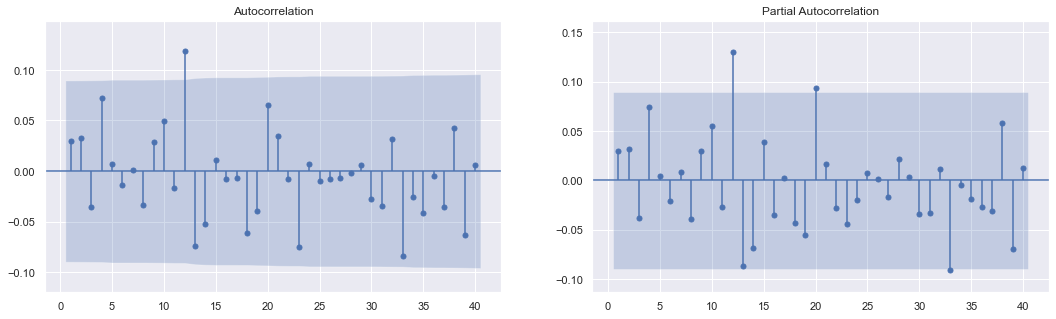

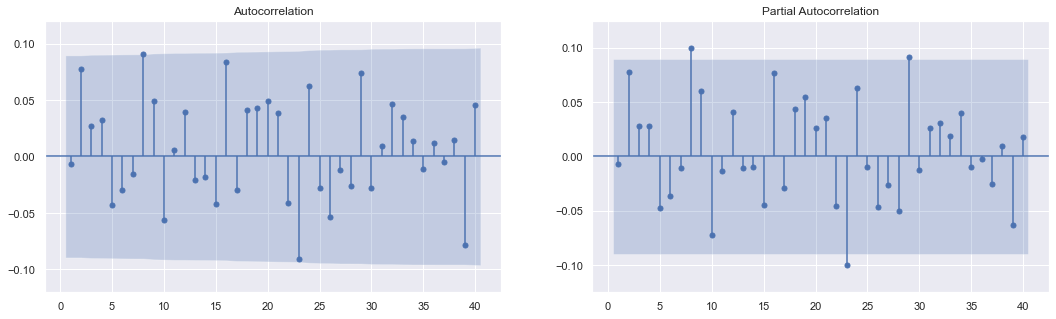

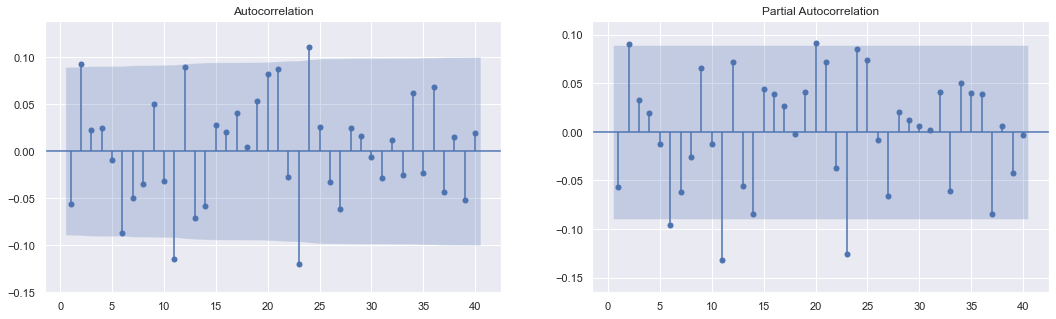

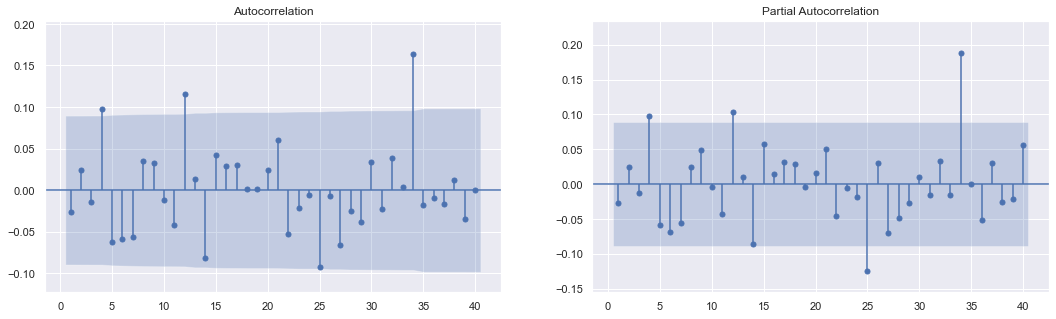

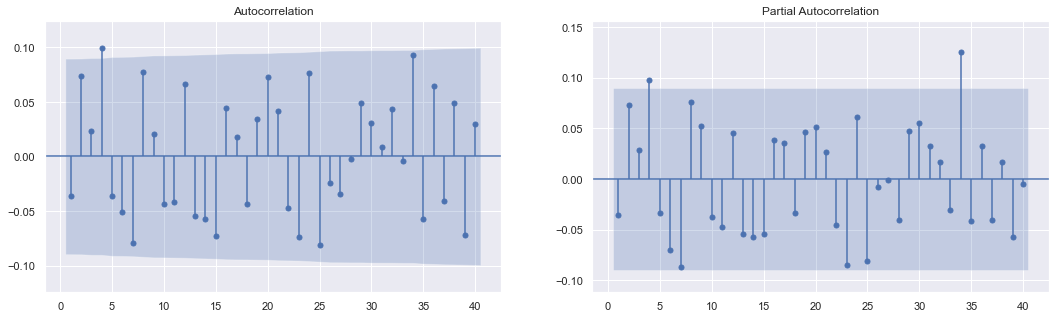

In [15]:
# train_df[crypto + "_log_diff"] = np.log(train_df[crypto].values)
for coin in tracked_coins:
    train_df[coin + '_log_diff'] = np.log(train_df[coin]).diff(1)
    df[coin + '_log_diff'] = np.log(df[coin]).diff(1)

for coin in tracked_coins[:5]:
    plot_acf_pacf(train_df[coin + "_log_diff"].dropna())
    adfuller(train_df[coin + "_log_diff"].dropna())

In [16]:
df.tail()

,DCR,CTSI,BTC,FTM,TRB,MANA,BAT,GXS,STORM,OMG,...,OGN_log_diff,XTZ_log_diff,KAVA_log_diff,CQT_log_diff,ANKR_log_diff,TROY_log_diff,XRP_log_diff,XEM_log_diff,KNC_log_diff,LRC_log_diff
Time,,,,,,,,,,,,,,,,,,,,,
2022-02-14 02:00:00,65.04,0.4286,41721.14,1.829,20.55,2.734,0.7780,0.8645,0.01085,4.511,...,-0.011818,0.004254,-0.004725,0.000000,-0.006595,-0.002547,0.002416,0.000922,0.008516,0.002602
2022-02-14 03:00:00,65.21,0.4333,41934.92,1.849,20.75,2.756,0.7859,0.8689,0.01090,4.552,...,0.002761,0.008191,0.009115,0.000000,0.012603,-0.000709,0.007339,-0.003693,0.010124,0.009335
2022-02-14 04:00:00,65.02,0.4321,41975.21,1.853,20.77,2.766,0.7878,0.8697,0.01091,4.531,...,0.011513,-0.004748,-0.000626,0.000000,0.002583,0.004386,0.001008,0.000925,-0.003925,-0.000112
2022-02-14 05:00:00,64.44,0.4274,41792.13,1.843,20.62,2.724,0.7811,0.8659,0.01087,4.491,...,-0.022882,-0.006100,-0.004078,0.002581,-0.014773,-0.002403,-0.009364,0.000924,-0.008463,-0.013299
2022-02-14 06:00:00,64.24,0.4355,42207.03,1.873,20.98,2.778,0.7919,0.8745,0.01097,4.541,...,-0.005873,0.007685,0.008140,0.007702,0.014501,0.004237,0.011377,0.003687,0.015182,0.018993


In [17]:
import pmdarima as pm

arima_models = {}
arima_params = {}
for coin in tracked_coins:
    model = pm.auto_arima(train_df[coin + '_log_diff'].dropna(), start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True,
                      scoring='mae', 
                      stepwise=True)
    arima_models[coin] = model
    arima_params[coin] = model.get_params()

print(arima_params)

{'DCR': {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mae', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}, 'CTSI': {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mae', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}, 'BTC': {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mae', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}, 'FTM': {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mae', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}, 'TRB': {'max

In [45]:
i = 0
for coin in tracked_coins:
    coin_df = pd.DataFrame()
    coin_df.index = df.index
    coin_df[coin + '_log_diff'] = df[coin + '_log_diff']
    coin_df[coin + '_1'] = df[coin].shift(1)
    coin_df.dropna(inplace=True)
    # df[coin + '_exp_pred'] = 0*df[coin + '_log_diff']
    df[coin + '_pred'] = 0*df[coin + '_log_diff']

    # init_train = coin_df[:window]
    # init_model = ARIMA(init_train, order=arima_params[coin])

    df_len = len(coin_df)
    # print(arima_params[coin]['order'])
    pred = [0]

    for index in range(window, df_len - 1):
        # print(coin_df.index[index + 1].hour)
        date_index = coin_df.index[index]
        if coin_df.index[index].hour == 0:

            train = np.array(coin_df[coin + '_log_diff'].values[index - window : index], dtype=float)
            # print(type(train))
            # print( arima_params[coin]['order'])
            model = ARIMA(train, order = arima_params[coin]['order'])
            model_fit = model.fit()
            pred = model_fit.forecast()
            # print(pred)
            # df[coin + '_exp_pred'][date_index] = pred[0]
            df[coin + '_pred'][date_index] = coin_df[coin + '_1'][date_index] * np.exp(pred[0])
            # print(df[coin + '_pred'][date_index])
    i += 1
    print('Step: ', i,'/', len(tracked_coins), ' for coin ', coin)



Step:  1 / 142  for coin  DCR
Step:  2 / 142  for coin  CTSI
Step:  3 / 142  for coin  BTC
Step:  4 / 142  for coin  FTM
Step:  5 / 142  for coin  TRB
Step:  6 / 142  for coin  MANA
Step:  7 / 142  for coin  BAT
Step:  8 / 142  for coin  GXS
Step:  9 / 142  for coin  STORM
Step:  10 / 142  for coin  OMG
Step:  11 / 142  for coin  STMX
Step:  12 / 142  for coin  WAN
Step:  13 / 142  for coin  IOST
Step:  14 / 142  for coin  NMR
Step:  15 / 142  for coin  FET
Step:  16 / 142  for coin  ICX
Step:  17 / 142  for coin  MATIC
Step:  18 / 142  for coin  SKL
Step:  19 / 142  for coin  VET
Step:  20 / 142  for coin  KEEP
Step:  21 / 142  for coin  ALGO
Step:  22 / 142  for coin  DOGE
Step:  23 / 142  for coin  AXS
Step:  24 / 142  for coin  TRX
Step:  25 / 142  for coin  BNT
Step:  26 / 142  for coin  SAND
Step:  27 / 142  for coin  RUNE
Step:  28 / 142  for coin  HBAR
Step:  29 / 142  for coin  WAVES
Step:  30 / 142  for coin  FUN
Step:  31 / 142  for coin  ARPA
Step:  32 / 142  for coin  CREA

In [53]:
for coin in [tracked_coins[0]]:
    df_check = df[[coin, coin + '_pred', coin + '_1']]

In [55]:
df_check.tail(50)

,DCR,DCR_pred,DCR_1
Time,,,
2022-02-12 05:00:00,65.40,0.000000,65.37
2022-02-12 06:00:00,64.83,-0.000000,65.40
2022-02-12 07:00:00,64.12,-0.000000,64.83
2022-02-12 08:00:00,64.94,0.000000,64.12
2022-02-12 09:00:00,65.16,0.000000,64.94
2022-02-12 10:00:00,65.00,-0.000000,65.16
2022-02-12 11:00:00,65.38,0.000000,65.00
2022-02-12 12:00:00,64.80,-0.000000,65.38
2022-02-12 13:00:00,64.45,-0.000000,64.80


In [43]:
coin_df[coin + '_log_diff'].values[0 : 2]

array([0.00766707, 0.00453598])

In [59]:
for coin in tracked_coins:
    df[coin + '_hourly_return'] = df[coin + '_pred'] / df[coin]
    df[coin + '_log_return'] = np.log(df[coin + '_hourly_return'])/24

In [60]:
for coin in tracked_coins:
    df_to_saved = pd.DataFrame(columns=['Value', 'hourly_return', 'log_return'], index=df.index)
    df_to_saved.Value = df[coin + '_pred']
    df_to_saved.hourly_return = df[coin + '_hourly_return']
    df_to_saved.log_return = df[coin + '_log_return']
    df_to_saved.dropna(inplace=True)
    
    df_to_saved.to_csv('./ARIMA_predictions/' + coin + '_ARIMA_predictions.csv')

In [46]:
df.tail(10)
df.to_csv('hourly_SARIMA_coins_prediction.csv')
# print(coin_df)

In [62]:
df = pd.read_csv('hourly_SARIMA_coins_prediction.csv')
df.index = pd.to_datetime(df.Time)
df.drop(['Time'], inplace=True, axis=1)

In [116]:
for coin in tracked_coins:
    df[coin + '_1'] = df[coin].shift(1)
    df[coin + '_pred'] = df[coin + '_1'] * np.exp(df[coin + '_exp_pred'])

In [ ]:
df_for_theo = df.copy()
interesting_col = [coin + "_pred" for coin in tracked_coins]
df_for_theo = df[interesting_col]
df_for_theo.head()
df_for_theo.to_csv('hourly_SARIMA_coins_prediction_for_theo.csv', sep='\t')

In [63]:
def get_sarima_mape(df, coin):
    # coin_df = df
    coin_df = df.drop(df[df.index.hour != 0].index)
    coin_df.drop(coin_df[coin_df[coin + "_pred"].isna() != 0].index, inplace=True)
    mape = mean_absolute_percentage_error(y_true = coin_df[coin], 
                                      y_pred = coin_df[coin + "_pred"])
    # print('Mape for ', coin, ': ', mape)
    return mape

In [64]:
mape = {}
for coin in tracked_coins:
    mape_coin = get_sarima_mape(df, coin)
    mape[coin] = mape_coin

In [65]:
import statistics
sarima_mape = [x[-1] for x in mape.items()]
average_mape = statistics.fmean(sarima_mape)
print(average_mape)

0.0459284966997354


In [66]:
for coin in tracked_coins:

    df[coin + "_close_log_diff"] = np.log(df[coin]).diff(1)

    df[coin + "_20_SMA"] = df[coin + "_close_log_diff"].shift(1).rolling(window = 500, min_periods = 1).mean()
    df[coin + "_SMA_preds_exp"] = np.exp(df[coin + "_20_SMA"].values)
    df[coin + "_SMA_preds"] = df[coin + "_SMA_preds_exp"] * df[coin + "_1"]

In [67]:
def get_SMA_mape(df, coin):
    # coin_df = df
    coin_df = df.drop(df[df.index.hour != 0].index)
    coin_df.drop(coin_df[coin_df[coin + "_SMA_preds"].isna() != 0].index, inplace=True)
    mape = mean_absolute_percentage_error(y_true = coin_df[coin], 
                                      y_pred = coin_df[coin + "_SMA_preds"])
    # print('Mape for ', coin, ': ', mape)
    return mape

In [68]:
SMA_mape = {}
for coin in tracked_coins:
    SMA_mape_coin = get_SMA_mape(df, coin)
    SMA_mape[coin] = SMA_mape_coin
SMA_mape = [x[-1] for x in SMA_mape.items()]
average_SMA_mape = statistics.fmean(SMA_mape)
print(average_SMA_mape)

0.01449524146038071


In [69]:
def get_lag_mape(df, coin):
    # coin_df = df
    coin_df = df.drop(df[df.index.hour != 0].index)
    coin_df.drop(coin_df[coin_df[coin + "_1"].isna() != 0].index, inplace=True)
    mape = mean_absolute_percentage_error(y_true = coin_df[coin], 
                                      y_pred = coin_df[coin + "_1"])
    # print('Mape for ', coin, ': ', mape)
    return mape

In [70]:
lag_mape = {}
for coin in tracked_coins:
    lag_mape_coin = get_lag_mape(df, coin)
    lag_mape[coin] = lag_mape_coin
lag_mape = [x[-1] for x in lag_mape.items()]
average_lag_mape = statistics.fmean(lag_mape)
print(average_lag_mape)

0.014436160032555745


In [71]:
from sklearn.metrics import accuracy_score

def calculate_signal_accuracy(price_lag, close_price, prediction):

    delta_real = close_price - price_lag
    delta_prediction = prediction - price_lag

    signal_real = np.where(delta_real > 0, 1, 0)
    signal_prediction = np.where(delta_prediction > 0, 1, 0)
    accuracy = accuracy_score(signal_real, signal_prediction)

    return accuracy

In [72]:
df.head()

,DCR,CTSI,BTC,FTM,TRB,MANA,BAT,GXS,STORM,OMG,...,XEM_SMA_preds_exp,XEM_SMA_preds,KNC_close_log_diff,KNC_20_SMA,KNC_SMA_preds_exp,KNC_SMA_preds,LRC_close_log_diff,LRC_20_SMA,LRC_SMA_preds_exp,LRC_SMA_preds
Time,,,,,,,,,,,,,,,,,,,,,
2019-07-01 01:00:00,30.62,NaN,10898.54,0.02711,NaN,0.05071,0.3239,2.093,0.002763,2.514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 02:00:00,31.10,NaN,10999.70,0.02751,NaN,0.04994,0.3155,2.197,0.002851,2.541,...,NaN,NaN,0.003571,NaN,NaN,NaN,0.007667,NaN,NaN,NaN
2019-07-01 03:00:00,31.28,NaN,11085.91,0.02704,NaN,0.05379,0.3311,2.134,0.002935,2.575,...,1.005813,0.092233,0.009460,0.003571,1.003577,0.253403,0.004536,0.007667,1.007697,0.055413
2019-07-01 04:00:00,31.25,NaN,11086.59,0.02757,NaN,0.04949,0.3305,2.125,0.002827,2.557,...,1.003285,0.092071,0.000784,0.006515,1.006537,0.256566,0.020427,0.006102,1.006120,0.055578
2019-07-01 05:00:00,31.16,NaN,11013.00,0.02739,NaN,0.04945,0.3247,2.120,0.002802,2.516,...,1.009740,0.094774,-0.007476,0.004605,1.004616,0.256277,-0.010878,0.010877,1.010936,0.056997


In [73]:
total_accuracy_lag = []
total_accuracy_SMA = []
total_accuracy_SARIMAX = []
df_accuracy = pd.DataFrame(columns=["accuracy_lag", "accuracy_SMA", "accuracy_SARIMAX","starting_on"], index=tracked_coins)

for coin in tracked_coins:

    coin_df = df.copy()

    coin_df.drop(coin_df[coin_df.index.hour != 0].index, inplace=True)
    coin_df.drop(coin_df[coin_df[coin + "_pred"].isna() != 0].index, inplace=True)

    accuracy_lag = calculate_signal_accuracy(coin_df[coin + "_1"], coin_df[coin], coin_df[coin + "_1"])
    accuracy_SMA = calculate_signal_accuracy(coin_df[coin + "_1"], coin_df[coin], coin_df[coin + "_SMA_preds"])
    accuracy_SARIMAX = calculate_signal_accuracy(coin_df[coin + "_1"], coin_df[coin], coin_df[coin + "_pred"])

    total_accuracy_lag.append(accuracy_lag)
    total_accuracy_SMA.append(accuracy_SMA)
    total_accuracy_SARIMAX.append(accuracy_SARIMAX)

    df_accuracy["accuracy_lag"][coin] = accuracy_lag
    df_accuracy["accuracy_SMA"][coin] = accuracy_SMA
    df_accuracy["accuracy_SARIMAX"][coin] = accuracy_SARIMAX
    df_accuracy["starting_on"][coin] = coin_df.index[0]

df_accuracy.to_csv('accuracy_scores.csv', sep=";", encoding="UTF-8")

In [74]:
print('Toal accuracy based on lag prediction: ', 100*statistics.fmean(total_accuracy_lag),'%')
print('Signal accuracy based on moving average prediction: ', 100*statistics.fmean(total_accuracy_SMA),'%')
print('Signal accuracy based on SARIMAX prediction: ', 100*statistics.fmean(total_accuracy_SARIMAX),'%')

Toal accuracy based on lag prediction:  52.82260199426096 %
Signal accuracy based on moving average prediction:  49.21690422948008 %
Signal accuracy based on SARIMAX prediction:  51.2551351623337 %
